In [3]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
from matplotlib.offsetbox import AnchoredText
import scipy.io
import pyBigWig
import gget
import pysam

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [4]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}
chromOrder = list(chromDict.values())

In [5]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_rnaseq/"

filepath = f"{dirpath}4DNESZ741PJM_processed_files_2022-05-30-14h-43m.tsv"
summary = pd.read_csv(filepath, sep='\t', comment='#')

summary['Filename'] = summary['File Download URL'].apply(lambda x: x.split("/")[-1])
cols = ['Filename', 'Experiment Accession', 'File Accession', 'Size (MB)', 'File Type', 'File Format',]
summary[cols]

,Filename,Experiment Accession,File Accession,Size (MB),File Type,File Format
0,4DNFI7FO9H19.bam,4DNEXCHOKPKJ,4DNFI7FO9H19,1503.75,read positions,bam
1,4DNFI8CSCJWM.tsv,4DNEXCHOKPKJ,4DNFI8CSCJWM,23.19,isoform expression,tsv
2,4DNFIUW8CG2I.bw,4DNEXCHOKPKJ,4DNFIUW8CG2I,42.86,read counts (plus),bw
3,4DNFIXOTRTRM.bw,4DNEXCHOKPKJ,4DNFIXOTRTRM,42.06,read counts (minus),bw
4,4DNFIYTCHMIZ.tsv,4DNEXCHOKPKJ,4DNFIYTCHMIZ,11.23,gene expression,tsv
5,4DNFI12AUKQS.bw,4DNEXGMSIOHL,4DNFI12AUKQS,31.51,read counts (plus),bw
6,4DNFI3YYNDKI.tsv,4DNEXGMSIOHL,4DNFI3YYNDKI,11.23,gene expression,tsv
7,4DNFIFVPB94O.bw,4DNEXGMSIOHL,4DNFIFVPB94O,30.93,read counts (minus),bw
8,4DNFIPYGE7JR.tsv,4DNEXGMSIOHL,4DNFIPYGE7JR,23.18,isoform expression,tsv
9,4DNFISUXPL3L.bam,4DNEXGMSIOHL,4DNFISUXPL3L,1063.16,read positions,bam


In [31]:
bamFilePath = f"{dirpath}4DNFI7FO9H19.bam"


chrom = 2
strChrom = f"chr{chrom}"
chromStart = assembly.loc[assembly['Chromosome'] == str(chrom)]['chromStart'].values[0]
chromEnd = assembly.loc[assembly['Chromosome'] == str(chrom)]['chromEnd'].values[0]
chromLen = int(chromEnd - chromStart)


def readCount(region, bamfile):
    """Compute the number of reads contained in a bamfile that overlap
    a given interval
    """
    bamIter = bamfile.fetch(region[0], region[1], region[2])
    regionCount = 0
    for x in bamIter:
        regionCount += 1
    return regionCount


def getTotalReads(bamfile):
    totalMappedReads = 0

    # here you want all reads
    bamIter = bamfile.fetch()

    for x in bamIter:
        totalMappedReads += 1
    return totalMappedReads


def getChromRPMK(bamfile, chrom, chromLen, resolution=1000000):
    """ A function to compute rpkm of each genomic bin"""
    
    strChrom = f"chr{chrom}"
    totalReads = getTotalReads(bamfile)
    newRows = []
    
    for i, b in enumerate(range(0, chromLen, resolution)):
        binStart = b
        binEnd = b + resolution - 1
        region = (strChrom, binStart, binEnd)
        
        readCounts = readCount(region, bamfile)
        
        rpkm = 1e9 * readCounts / (totalReads * 1000000)
        
        row = {
            'bin' : i,
            'binStart' : binStart,
            'binEnd' : binEnd,
            'chrom': strChrom,
            'rpkm' : rpkm
        }
        
        newRows.append(row)
        
    return pd.DataFrame(newRows)
        
df = getChromRPMK(bamfile, 2, chromLen, resolution=1000000)
print(f"{df.shape=}")
df.head()

df.shape=(182, 5)


,bin,binStart,binEnd,chrom,rpkm
0,0,0,999999,chr2,0.000000
1,1,1000000,1999999,chr2,0.000000
2,2,2000000,2999999,chr2,0.000000
3,3,3000000,3999999,chr2,0.276760
4,4,4000000,4999999,chr2,0.204626


In [35]:
outpath = "filtered_data/nagano2017rpkm1Mb.csv"
df.to_csv(outpath, index=False)

<BarContainer object of 182 artists>

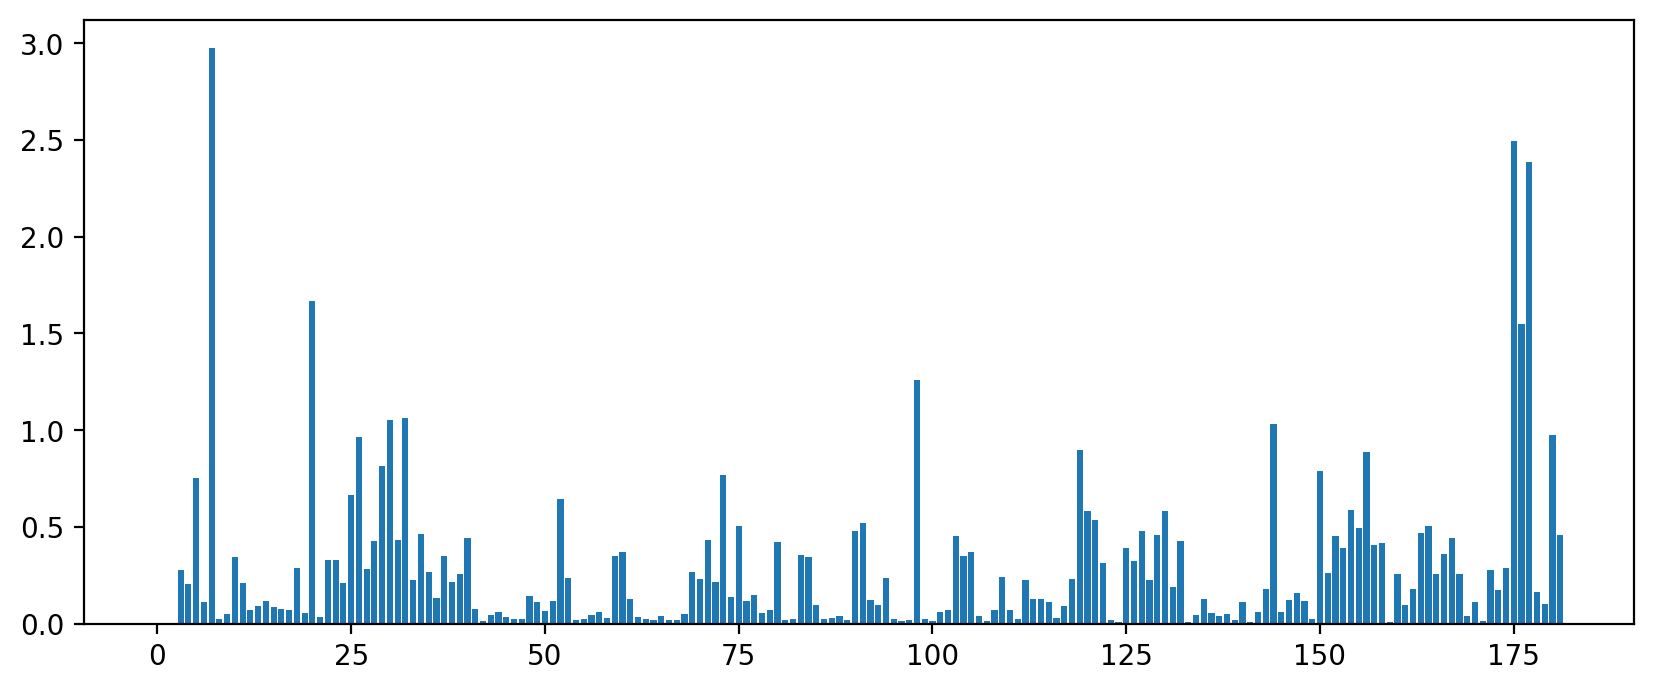

In [34]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 4

plt.bar(range(len(df)), df['rpkm'])